In [1]:
%matplotlib inline
#%matplotlib notebook
from universal import *

from scipy.optimize import minimize
from scipy.misc import derivative
from scipy.interpolate import interp2d
from scipy import signal
import cPickle as pickle

In [2]:
def plot_config():
    from cycler import cycler
    from matplotlib.ticker import AutoMinorLocator

    fsize = 14 # a quarter of the paper width: 20 pt; half of the paper width: 12
    font = {'size' : fsize, 'family' : 'serif'}
    color_cycle = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    linestyle_cycle = ['-', '--', '-.', ':', (0, (5, 2, 5, 2)), (0, (10, 2, 5, 2, 2, 2)), (0, (12, 2, 2, 2))]
    marker_cycle = ['o', 'd', 'v', '^', '<', '>', '*']
    
    mpl.rc('font', **font)
    mpl.rc('xtick', labelsize = 10, direction = 'in', top   = True)
    mpl.rc('ytick', labelsize = 10, direction = 'in', right = True)
    mpl.rc('xtick.major', size = 5, width = 1)
    mpl.rc('ytick.major', size = 5, width = 1)
    mpl.rc('xtick.minor', size = 3, width = 0.7, visible = True)
    mpl.rc('ytick.minor', size = 3, width = 0.7, visible = True)
    
    mpl.rc('lines', linewidth=2, markersize=6, color='r')
    # mpl.rc('lines', linestyle = 'solid')
    mpl.rc('axes', labelpad = 0, prop_cycle=(cycler('color', color_cycle) + cycler('linestyle', linestyle_cycle) + cycler('marker', marker_cycle)))
    mpl.rc('legend', fontsize = 12, labelspacing = 0.05, handletextpad=0.4, frameon=False, handlelength=2.1)
    
    mpl.rc('figure', dpi = 100, figsize = (4, 4))
    mpl.rc('figure.subplot', bottom = 0.15, top = 0.9, left = 0.15, right = 0.9)
    
    mpl.rc('image', cmap = 'jet')
    
    return
plot_config()

rootdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work'
simdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\sim'

In [3]:
dt = 10e-12
dz = g_c*dt; print 'Light travelled: ', dz*1e3
EG = 30*dz
gg = kinetic2gamma(EG); print 'Gamma: ', gg
bb = gamma2beta(gg); print 'Beta: ', bb/2
dz = bb*g_c*dt
print 'Excursion: ', dz*1e3

Light travelled:  2.99792458
Gamma:  1.17600376299
Beta:  0.26311892769329304
Excursion:  1.577621401589932


## Radial space charge calculated by analytical formula

In [143]:
rho_z = lambda z, sigma_z: 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-z**2/2./sigma_z**2)
rho_r = lambda r, sigma_r: 1./(2.*np.pi)/sigma_r**2*np.exp(-r**2/2./sigma_r**2)

fEr = lambda r, z, sigma_r, sigma_z, gamma, Qtot:\
       Qtot*rho_z(z*gamma, sigma_z*gamma)/(2.*np.pi*r*g_eps0)*(1.-np.exp(-r**2/2./sigma_r**2))*gamma

Text(0,0.5,'$E_r(z)$ (V/m)')

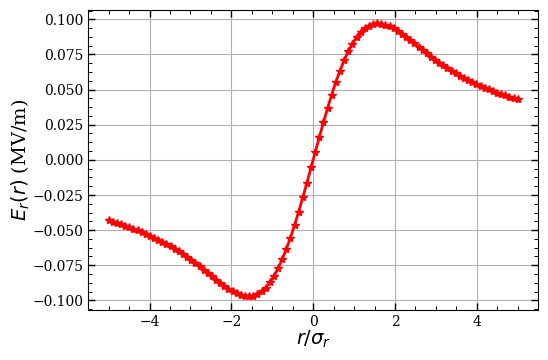

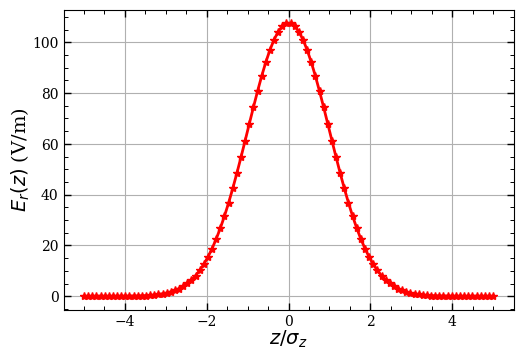

In [145]:
Qtot = 30e-12; sigma_r = 1.0e-3; sigma_z = 1.0e-3
gamma = 1. #+16./g_mec2

rr = np.linspace(-5*sigma_r, 5*sigma_r, 100)
Er_r = fEr(rr, 0, sigma_r, sigma_z, gamma, Qtot)/gamma**2
zz = np.linspace(-5*sigma_z, 5*sigma_z, 100)
Er_z = fEr(1e-6, zz, sigma_r, sigma_z, gamma, Qtot)/gamma**2

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(rr/sigma_r, Er_r/1e6, '-*')
ax.grid()
ax.set_xlabel(r'$r/\sigma_r$')
ax.set_ylabel(r'$E_r(r)$ (MV/m)')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(zz/sigma_z, Er_z, '-*')
ax.grid()
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_r(z)$ (V/m)')

## Space charge in 3D coordinate system

In [5]:
from tracking import *

In [ ]:
Qtot = 3e9*g_qe; sigma_x = 70e-6; sigma_y = 7.5e-6; sigma_z = 7.0e-3; gamma = 1.+1300./g_mec2
sc = SpaceCharge3D(Qtot, sigma_x, sigma_y, sigma_z, gamma)
yy = 1.0*sigma_y
print sc.fEy(0, 10e-6, 0), sc.fEy1(0, 10e-6, 0)
#print sc.fEx(v, 0, 0)

## Space charge in $R-Z$ coordinate system

In [80]:
from tracking import *

In [81]:
Qtot = 30e-12; sigma_r = 1e-3; sigma_z = 1e-3; gamma = 1. #+150./g_mec2; print gamma
nr = 16; nz = 16; dr = 5*sigma_r/nr; dz = 5*sigma_z/nz

import timeit
#sc3d = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
scrz = SpaceChargeRZ(Qtot, sigma_r, sigma_z, nr, nz, gamma)
# time1 = timeit.default_timer()
scrz.build()
# time2 = timeit.default_timer()
# print time2-time1

# rr = np.arange(0, 5*sigma_r, dr)+dr/2.
# zz = np.arange(-5*sigma_z, 5*sigma_z, dz)+dz/2.
r0, z0 = dr/2., dz/2.
print r0, z0

time1 = timeit.default_timer()
phi = scrz.phi_static_RZ(r0*7, z0)
time2 = timeit.default_timer()
print time2-time1, ': ', phi

time1 = timeit.default_timer()
phi = scrz.phi_static(r0, z0)
time2 = timeit.default_timer()
print time2-time1, ': ', phi

# time1 = timeit.default_timer()
# phi = scrz.phi_static_RZ(r0, z0)
# time2 = timeit.default_timer()
# print time2-time1, ': ', phi

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
0.00015625 0.00015625
0.0290394000003 :  187.15750604015918
853.668245178953
0.00977369999964 :  214.36798609137747


[ 12263.20901055  13168.33553977  15191.03941735  17702.88606817
  20846.40475884  24781.10182317  29641.28713733  35444.66811064
  41944.04050869  48451.04982269  53718.92476587  56016.73809357
  53503.24327218  44874.77948676  30059.87075943  10596.85618021
 -10596.85618021 -30059.87075943 -44874.77948677 -53503.24327218
 -56016.73809357 -53718.92476587 -48451.04982269 -41944.04050869
 -35444.66811064 -29641.28713733 -24781.10182317 -20846.40475884
 -17702.88606817 -15191.03941735 -13168.33553977 -12263.20901055]


Text(0,0.5,'$E_z(z)$ (MV/m)')

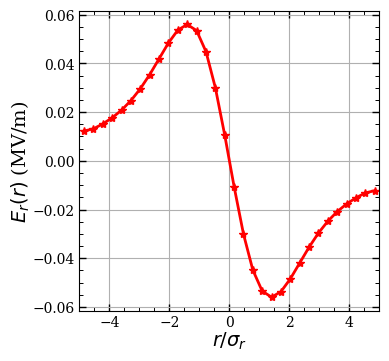

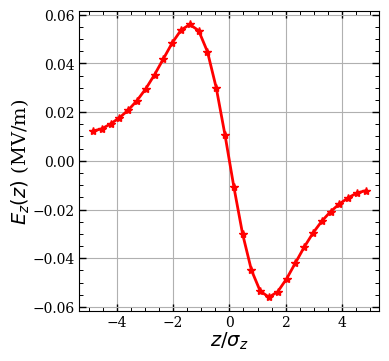

In [82]:
rr = np.arange(-5*sigma_r, 5*sigma_r, dr)+dr/2.
zz = np.arange(-5*sigma_z, 5*sigma_z, dz)+dz/2.

R, Z = np.meshgrid(rr, zz)
Er = np.array([scrz.EM3D(r, 0, 0)[0]-scrz.EM3D(r, 0, 0)[4] for r in rr]); print Er
Ez = np.array([scrz.EM3D(0, 0, z)[2] for z in zz])
#np.savetxt('static_RZ_64x16.dat', np.array([rr, Er]).T, fmt='%12.4E')

def fEr(r, sigma_r, Qtot):
    if abs(r) < sigma_r:
        return Qtot/4./np.pi/g_eps0*r/sigma_r**3
    else:
        return Qtot/4./np.pi/g_eps0*r/r**2/abs(r)
#Er_0 = np.array([-fEr(rp, sigma_r, Qtot) for rp in rr])

fig, ax = plt.subplots()
ax.plot(rr/sigma_r, Er/1e6, '-*')
ax.set_xlim(-5, 5)
#ax.set_ylim(0, 100000)
#ax.plot(rr*1e6, Er_0, '-*')
phi = np.array([scrz.phi_2d(r, 0)[0] for r in rr])
#ax.plot(rr*1e3, phi*1e5, '-*')
#ax.plot(rr*1e6, np.gradient(phi, 5.*sigma_r/nr), '-*')
ax.grid()
ax.set_xlabel(r'$r/\sigma_r$')
ax.set_ylabel(r'$E_r(r)$ (MV/m)')

fig, ax = plt.subplots()
ax.plot(zz/sigma_z, Ez/1e6, '-*')
phi = np.array([scrz.phi_2d(0, z)[0] for z in zz])
#ax.plot(zz*1e3, phi*1e5, '-')
#ax.plot(zz*1e6, np.gradient(phi, 5.*sigma_z/nz), '-*')
ax.grid()
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z(z)$ (MV/m)')

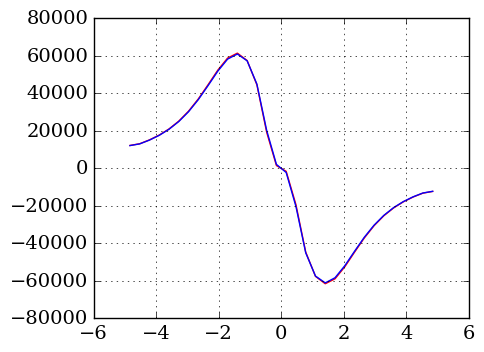

In [121]:
data = np.loadtxt('static_RZ.dat')
#plt.plot(data[:,0]*1e3, data[:,1], '-')
data = np.loadtxt('static_RZ3.dat')
plt.plot(data[:,0]*1e3, data[:,1], '-')
data = np.loadtxt('static_RZ4.dat')
plt.plot(data[:,0]*1e3, data[:,1], '-')
plt.grid()
#plt.xlim(0,5)
plt.show()

In [3]:
### generate 3D distribution
sigma_r = 1.0e-6; sigma_z = 1.0e-6; nr = 32; nz = 64

mean = [0, 0, 0]
cov = [[sigma_r**2, 0, 0], [0, sigma_r**2, 0], [0, 0, sigma_z**2]]
x, y, z = np.random.multivariate_normal(mean, cov, 100000).T

dr = 5*sigma_r/nr; dz = 5*sigma_z/nz
rr = np.linspace(0, 5*sigma_r, nr)
zz = np.linspace(-5*sigma_r, 5*sigma_r, 2*nz+1)

global rho;
rho = np.zeros((nr, nz*2+1))

for i in np.arange(len(x)):
    ir = int(np.sqrt(x[i]**2+y[i]**2)/dr+0.)
    if z[i]>=0:
        iz = nz+int(z[i]/dz+0.5)
    else:
        iz = nz-int(-z[i]/dz+0.5)
    if ir>=0 and ir<nr and iz>=0 and iz < nz*2+1:
        rho[ir, iz] += 1.
#print rho.sum(axis=0)
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(z*1e6, y*1e6, '.')
ax.grid()
ax.axis([-4, 4, -4, 4])

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(rr*1e6, rho.sum(axis=1), '-*'); ax.hist(np.sqrt(x**2+y**2)*1e6, bins=32)
#ax.plot(zz*1e6, rho[3,:], '-*'); #ax.hist(z*1e6, bins=32)
ax.grid()

In [54]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6

mean = [0, 0, 0]
cov = [[sigma_r**2, 0, 0], [0, sigma_r**2, 0], [0, 0, sigma_z**2]]

xb, yb, zb = np.random.multivariate_normal(mean, cov, 100000).T

### Comparison

The 3D method gives accurate solutions to the space charge forces, while the RZ method is only valid when gamma is small. The reason lies that when gamma is very large, the discrete charge rings are far from the point concerned and the coulomb force is under estimated, due to the inverse square law. The radial component can be easily calculated using the analytical formula, which is only valid for relativistic beam with a large aspect ratio.

In [55]:
nr = 40; nz = 200; gamma = 10.#+150./g_mec2; print gamma

sc3d = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
sc2d = SpaceChargeRZ(Qtot, sigma_r, sigma_z, nr, nz, gamma)
sc.get_rho_RZ(xb, yb, zb)

#rp, zp = sc.dr*(8+0.5), sc.dz*(20+0.5) ; print rp, zp
rp, zp = 1.0625e-6, 1.0625e-6
print sc3d.fEx(rp, 0, zp)/1e9, sc3d.fEz(rp, 0, zp)/1e9
print sc.fEr(rp, zp, 0)/1e9, sc.fEz(rp, zp, 0)/1e9
print sc.fEr(rp, zp, 1)/1e9, sc.fEz(rp, zp, 1)/1e9
print fEr(rp, zp, sigma_r, sigma_z, gamma, Qtot)/1e9

1.64781491978 0.0865035955797
[ 1.63097047] [ 0.09146845]
1.65547358533


### Calculation of space charge using 3D

In [106]:
Qtot = 3e9*g_qe; sigma_x = 70e-6; sigma_y = 7.5e-6; sigma_z = 7.0e-3; gamma = 1.+1300./g_mec2
sc = SpaceCharge3D(Qtot, sigma_x, sigma_y, sigma_z, gamma)
yy = -1.0*np.array([3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_y
Ey_y = np.array([])
Ey_y = np.zeros(len(yy))
for i, v in enumerate(yy):
    Ey_y[i] = sc.fEy(0, v, 0)
    print Ey_y[i],',',

KeyboardInterrupt: 

In [87]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2

sc = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_z
Ez_z = np.zeros(len(zz))
for i, v in enumerate(zz):
    Ez_z[i] = sc.fEz(0, 0, v)
    print Ez_z[i],',', 

In [71]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ez_z = np.array([-1068.71155235, -1329.53950284, -1701.24698937, -2259.18565239, -3159.65480883, -3839.9478985,\
                 -6258.93259551, -8938.47979824, -15170.6328943, -31536.0527241, -70891.8916114, -144539.35086,\
                 -235874.717597, -269004.384616, -278927.714006, -256341.826416, -197732.48045, -107937.469484, 0])

In [36]:
Qtot = 50e-12; sigma_r = 0.6e-6; sigma_z = 1.0e-6; gamma = 150./g_mec2+1; 
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ez_z = np.array([-53435.5903638, -66476.9950999, -85062.3827171, -112959.342919, -157982.864754, -191997.588353,\
                 -313328.084992, -449759.290142, -774702.576927, -1647178.35564, -3776520.26685, -7798420.90377,\
                 -12821018.2989, -14658361.6471, -15227062.9301, -14012182.3256, -10818082.5589, -5908374.12811, 0])

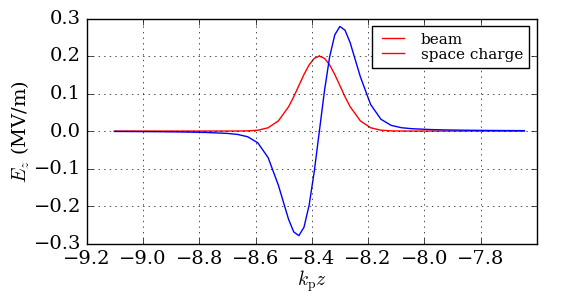

In [78]:
lpc = PlasmaChannel(ne = 1.5e23); lamp = lpc.wavelength(); kp = 2.*np.pi/lamp
beam_zc = -4-60e-6*kp

fig, ax = plt.subplots(figsize=(6,3))
ax.plot( zz*kp+beam_zc, gaussian( zz*kp+beam_zc, 1e-6*kp, beam_zc, 0.2), 'r-')
ax.plot(-zz*kp+beam_zc, gaussian(-zz*kp+beam_zc, 1e-6*kp, beam_zc, 0.2), 'r-')
ax.plot( zz*kp+beam_zc,  Ez_z/1e6, 'b-')
ax.plot(-zz*kp+beam_zc, -Ez_z/1e6, 'b-')
ax.grid()
ax.set_xlabel(r'$k_{\rm p}z$')
ax.set_ylabel(r'$E_z$ (MV/m)')
ax.legend([r'beam', r'space charge'])
#ax.set_xlim(-21, 0)
#fig.savefig('space-charge-50pC'+figtype)

In [86]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
sc = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
xx = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_r
# Ex_x = np.array(-59707075934.7, -66350871987.8, -74654763320.6, -85330177721.7, -99562821590.1, -108619429210.0,\
#                 -132764203145.0, -149321525576.0, -170343103058.0, -196962902383.0, -228515206451.0, -258341977376.0,\
#                 -161415282712.0, -155502256288.0, -141063532600.0, -117193111286.0, -84256877214.5, -44123794492.0)
Ex_x = np.zeros(len(xx))
for i, v in enumerate(xx):
    Ex_x[i] = sc.fEx(v, 0, 0)
    print Ex_x[i],',',

In [89]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
xx = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_r
Ex_x = np.array([-715601723.284, -795391164.78, -895104740.916, -1023279988.76, -1194145916.5, -1302863999.23,\
                 -1592682854.87, -1791413837.0, -2043717741.79, -2363202504.24, -2741879971.6, -3099854264.60,\
                 -3228305654.24, -3110045125.8, -2821321192.07, -2343859039.70, -1685042467.6, -882358273.419, 0])

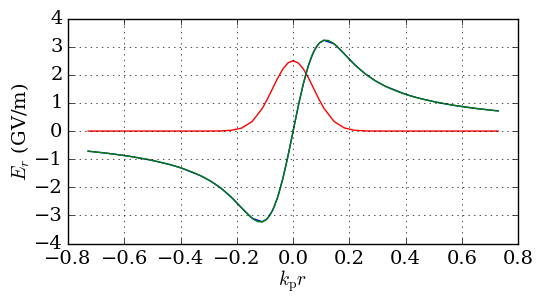

In [97]:
lpc = PlasmaChannel(ne = 1.5e23); lamp = lpc.wavelength(); kp = 2.*np.pi/lamp

fig, ax = plt.subplots(figsize=(6,3))
ax.plot( xx*kp, gaussian( xx*kp, 1e-6*kp, 0, 2.5), 'r-')
ax.plot(-xx*kp, gaussian(-xx*kp, 1e-6*kp, 0, 2.5), 'r-')
ax.plot( xx*kp,  Ex_x/1e9, 'b-')
ax.plot(-xx*kp, -Ex_x/1e9, 'b-')
rr = np.linspace(-10, 10, 100)*sigma_r
Er_r = fEr(rr, 0, sigma_r, sigma_z, gamma, Qtot)
ax.plot(rr*kp, Er_r/1e9, 'g-')
ax.grid()
ax.set_xlabel(r'$k_{\rm p}r$')
ax.set_ylabel(r'$E_r$ (GV/m)')
#ax.legend([r'beam', r'space charge'])
#ax.set_xlim(-21, 0)
#fig.savefig('space-charge-50pC'+figtype)

In [27]:
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ex_z = np.array([62057.3771687, 86475.3616713, 125951.804807, 194666.540523, 327772.661093, 446178.515856,\
                2299467.77799, 12623656.7501, 74092275.857, 364422133.978, 1421697980.49, 4345913764.51,\
                10375473897.8, 14606829181.1, 19325039251.5, 24026155099.5, 28069625683.3, 30815593716.5,\
                31789393945.8])
np.savetxt('beam-loading/space-charge.dat', np.array([zz, Ez_z, Ex_z]).T, fmt = '%12.6E')
#xx = np.linspace(-10*sigma_r, 10*sigma_r, 20)
#Ex_z = np.zeros(len(zz))
for i, v in enumerate(zz):
    #Ex_z[i] = SC_Ex(45e-6/4., 0, v, sigma_r, sigma_z, gamma)
    print Ex_z[i], 

62057.3771687 86475.3616713 125951.804807 194666.540523 327772.661093 446178.515856 2299467.77799 12623656.7501 74092275.857 364422133.978 1421697980.49 4345913764.51 10375473897.8 14606829181.1 19325039251.5 24026155099.5 28069625683.3 30815593716.5 31789393945.8


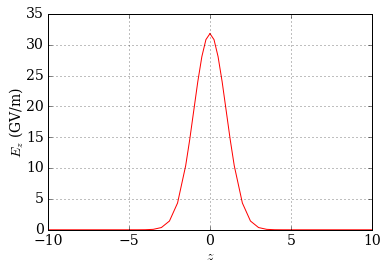

In [8]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(zz/sigma_z, Ex_z/1e9, '-')
ax.plot(-zz/sigma_z, Ex_z/1e9, 'r-')
ax.grid()
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$E_x$ (GV/m)')

# FFT

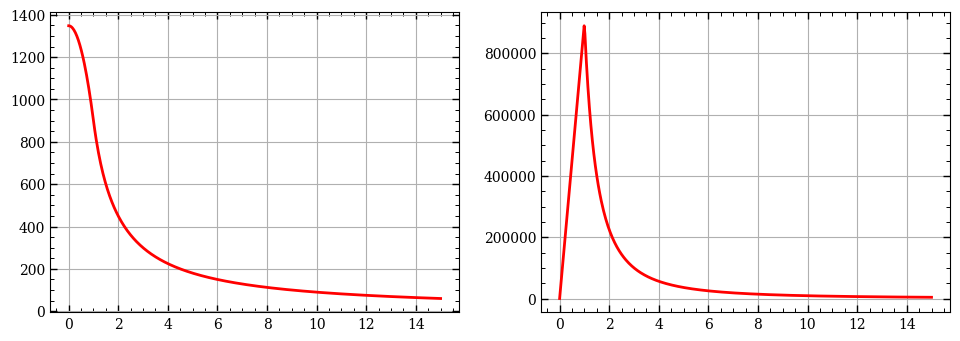

In [784]:
def static_potential(r, R, Q = 100e-12):
    cc = Q/4./np.pi/g_eps0
    if r<=R:
        phi = cc*((R**2-r**2)/2./R**3+1./R)
    else:
        phi = cc/r
    return phi
def electric_field(r, R, Q = 100e-12):
    cc = Q/4./np.pi/g_eps0
    if r<=R:
        Er = cc*r/R**3
    else:
        Er = cc/r**2
    return Er

R = 1e-3
r = np.linspace(0, 15*R, 501)
phi = np.array([static_potential(x, R) for x in r])
Er = np.array([electric_field(x, R) for x in r])

fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
ax1.plot(r/R, phi, '-')
ax1.grid()
ax2.plot(r/R, Er, '-')
ax2.grid()

np.savetxt('R1mm.dat', np.array([r, phi, Er]).T, fmt = '%12.6E')

In [947]:
def GF3D((x, y, z)):
    '''
    Green function (GF) in 3D cartesian CS
    '''
    r = np.sqrt(x*x+y*y+z*z)
    return np.where(r>0, 1./np.sqrt(x*x+y*y+z*z), 1e100)
def IGF3D((x, y, z)):
    '''
    Indefinite integral of or integrated green function in 3D cartesian CS, according to Eq.(2) on 129901-2. 
    Here, `indefinite` refers to the integrating limits
    ''' 
    r = np.sqrt(x*x+y*y+z*z)
    
    #EPS = 1e-12
    #if abs(r) < EPS:
    #    return 0
    #if abs(x) < EPS:
    #    return y*z*np.log(r)
    #if abs(y) < EPS:
    #    return z*x*np.log(r)
    #if abs(z) < EPS:
    #    return x*y*np.log(r)
    
    x2 = x*x; y2 = y*y; z2 = z*z
    xy = x*y; yz = y*z; zx = z*x
    s = yz*np.log(x+r)+zx*np.log(y+r)+xy*np.log(z+r)
    a = -0.5*x2*np.arctan(yz/x/r)
    b = -0.5*y2*np.arctan(zx/y/r)
    c = -0.5*z2*np.arctan(xy/z/r)
    return s+a+b+c

def integral_IGF3D(xp, yp, zp, hx, hy, hz):
    '''
    Integral of green function in 3D cartesian CS
    Parameters
      xp: center of the volume in x direction
      yp: center of the volume in y direction
      zp: center of the volume in z direction
      hx: length of the volume in x direction
      hy: length of the volume in y direction
      hz: length of the volume in z direction
    Returns
      rr: integral over a volume defined by (xp, yp, zp, hx, hy, hz)
    '''
    xl, xu, yl, yu, zl, zu = xp-hx/2., xp+hx/2., yp-hy/2., yp+hy/2., zp-hz/2., zp+hz/2.
    rr = (IGF3D((xu, yu, zu))-IGF3D((xu,yl,zu))-IGF3D((xl,yu,zu))+IGF3D((xl,yl,zu)))-\
         (IGF3D((xu, yu, zl))-IGF3D((xu,yl,zl))-IGF3D((xl,yu,zl))+IGF3D((xl,yl,zl)))
    return rr
def transposed_IGF3D(x, y, z, xp, yp, zp, hx, hy, hz):
    '''
    Transposed finite integral of green function in 3D Cartesian CS
    Parameters
      xp: center of the volume in x direction
      yp: center of the volume in y direction
      zp: center of the volume in z direction
      hx: length of the volume in x direction
      hy: length of the volume in y direction
      hz: length of the volume in z direction
    '''
    xl, xu, yl, yu, zl, zu = x-xp+hx/2., x-xp-hx/2., y-yp+hy/2., y-yp-hy/2., z-zp+hz/2., z-zp-hz/2.
    rr = (IGF3D(xu, yu, zu)-IGF3D(xu,yl,zu)-IGF3D(xl,yu,zu)+IGF3D(xl,yl,zu))-\
         (IGF3D(xu, yu, zl)-IGF3D(xu,yl,zl)-IGF3D(xl,yu,zl)+IGF3D(xl,yl,zl))
    return -rr

In [948]:
Qtot = 100e-12
sigma_x = 1e-3; sigma_y = 1e-3; sigma_z = 1e-3
Nx, Ny, Nz, Nc = 32, 32, 32, 1.5
hx, hy, hz = sigma_x*2*Nc/Nx, sigma_y*2*Nc/Ny, sigma_z*2*Nc/Nz; print hx
xc, yc, zc = Nc*sigma_x, Nc*sigma_y, Nc*sigma_z
xf = 5*sigma_x; yf = 0*sigma_y; zf = 0*sigma_z; # distance from field domain center to charge domain center
xleft = Nc*sigma_x

def density0((x, y, z)):
    '''
    3D Gaussian distribution
    '''
    f_x = 1./np.sqrt(2.*np.pi)/sigma_x*np.exp(-(x-xc)**2/2./sigma_x**2)
    f_y = 1./np.sqrt(2.*np.pi)/sigma_y*np.exp(-(y-yc)**2/2./sigma_y**2)
    f_z = 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-zc)**2/2./sigma_z**2)
    return f_x*f_y*f_z
def density((x, y, z)):
    '''
    3D uniform distribution in a sphere
    '''
    r = np.sqrt((x-xc)**2+(y-yc)**2+(z-zc)**2)
    rho = np.where(r>sigma_x, 0, 3./(4*np.pi*sigma_x**3))
    return rho

def cyclic_IGF3D((i, j, k)):
    '''
    Cyclic integrated GF
    '''
    xi = np.where(i<Nx, xf+i*hx, xf-(2*Nx-i)*hx)
    yj = np.where(j<Ny, yf+j*hy, yf-(2*Ny-j)*hy)
    zk = np.where(k<Nz, zf+k*hz, zf-(2*Nz-k)*hz)
    
    GF = integral_IGF3D(xi, yj, zk, hx, hy, hz)
    #GF = GF3D(xi, yj, zk)
    return GF
def cyclic_density((i, j, k)):
    '''
    Cyclic charge density
    '''
    xi, yj, zk = i*hx, j*hy, k*hz
    rho = np.where(i.any()>Nx or j.any()>Ny or k.any()>Nz, 0, density((xi, yj, zk)))
    return rho
def cyclic_IGF3D_mapping((i, j, k), IGF_MAP):
    # n = np.array([-1, 1, 1, -1, 1, -1, -1, 1])
    # v = np.array([IGF_MAP[i, j, k], IGF_MAP[i, j, k+1],\
    #              IGF_MAP[i, j+1, k], IGF_MAP[i, j+1, k+1],\
    #              IGF_MAP[i+1, j, k], IGF_MAP[i+1, j, k+1],\
    #              IGF_MAP[i+1, j+1, k], IGF_MAP[i+1, j+1, k+1]])
    rr = -IGF_MAP[i, j, k] +IGF_MAP[i, j, k+1]  +IGF_MAP[i, j+1, k]  -IGF_MAP[i, j+1, k+1]+\
         IGF_MAP[i+1, j, k]-IGF_MAP[i+1, j, k+1]-IGF_MAP[i+1, j+1, k]+IGF_MAP[i+1, j+1, k+1]
    return rr

9.375e-05


In [949]:
from numpy.fft import fftn, ifftn

GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

import timeit
time1 = timeit.default_timer()

ii = np.arange(2*Nx)
jj = np.arange(2*Ny)
kk = np.arange(2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
RHOC = cyclic_density(II)

time2 = timeit.default_timer()

# Calculate GFs without using the mapping, slow
GFC = cyclic_IGF3D2(II)

time3 = timeit.default_timer()

print time2-time1
print time3-time2

0.0169945000089
0.416821499995


In [950]:
from numpy.fft import fftn, ifftn

GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

import timeit
time1 = timeit.default_timer()

ii = np.arange(2*Nx)
jj = np.arange(2*Ny)
kk = np.arange(2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
RHOC = cyclic_density(II)

time2 = timeit.default_timer()

# Calculate GFs by using the mapping, faster
xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
zz = zf-Nz*hz+np.arange(2*Nz+1)*hz-0.5*hz
XX = np.meshgrid(xx, yy, zz, indexing = 'ij')
IGF_MAP = IGF3D(XX)

time3 = timeit.default_timer()

ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

time4 = timeit.default_timer()

print time2-time1
print time3-time2
print time4-time3
print time4-time2

0.0161569999764
0.056957599998
0.0475659000222
0.10452350002


In [951]:
GFC_FFT = fftn(GFC)
RHOC_FFT = fftn(RHOC)
PHIC_FFT = GFC_FFT*RHOC_FFT

PHIC = ifftn(PHIC_FFT)
PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]

Text(0.5,1,'static potential')

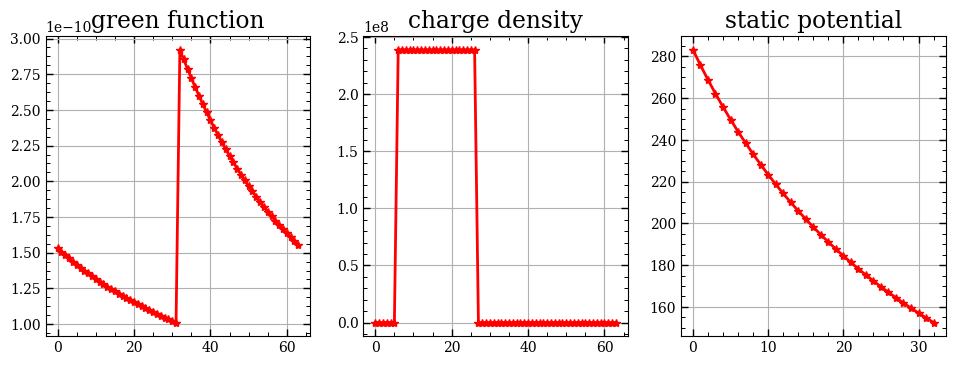

In [952]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
ax1.grid()
ax1.set_title(r'green function')
ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
ax2.grid()
ax2.set_title(r'charge density')
ax3.plot(PHI[:, Ny/2-1, Nz/2-1], '-*')
ax3.grid()
ax3.set_title(r'static potential')

In [953]:
Ex, Ey, Ez = np.gradient(PHI, hx, hy, hz)

(0, 500)

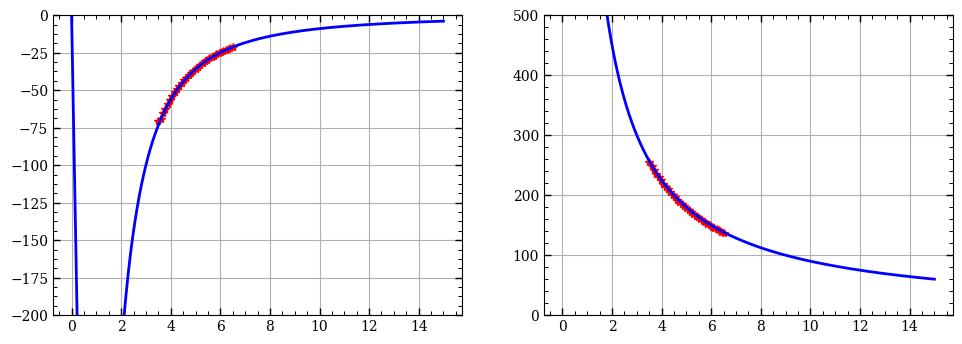

In [954]:
rr = np.linspace(-Nc*sigma_x, Nc*sigma_x, Nx+1)+hx/2.+xf

data = np.loadtxt('R1mm.dat')

fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
ax1.plot((rr-hx/2)/sigma_x, Ex[:, Ny/2-1, Nz/2-1]*Qtot/4/np.pi/g_eps0/1e3, '-*')
ax1.plot(data[:,0]/sigma_x, -data[:,2]/1e3, '-')
ax1.set_ylim(-200, 0)
ax1.grid()

ax2.plot((rr-hx/2)/sigma_x, PHI[:, Ny/2-1, Nz/2-1]*Qtot/4/np.pi/g_eps0, '-*')
ax2.plot(data[:,0]/sigma_x, data[:,1], '-')
ax2.grid()
ax2.set_ylim(0, 500)

In [12]:
def GF3D((x, y, z)):
    '''
    Green function (GF) in 3D cartesian CS
    '''
    r = np.sqrt(x*x+y*y+z*z)
    return np.where(r>0, 1./np.sqrt(x*x+y*y+z*z), 1e100)
def IGF3D((x, y, z)):
    '''
    Indefinite integral of or integrated green function in 3D cartesian CS, according to Eq.(2) on 129901-2. 
    Here, `indefinite` refers to the integrating limits
    ''' 
    r = np.sqrt(x*x+y*y+z*z)
    
    #EPS = 1e-12
    #if abs(r) < EPS:
    #    return 0
    #if abs(x) < EPS:
    #    return y*z*np.log(r)
    #if abs(y) < EPS:
    #    return z*x*np.log(r)
    #if abs(z) < EPS:
    #    return x*y*np.log(r)
    
    x2 = x*x; y2 = y*y; z2 = z*z
    xy = x*y; yz = y*z; zx = z*x
    s = yz*np.log(x+r)+zx*np.log(y+r)+xy*np.log(z+r)
    a = -0.5*x2*np.arctan(yz/x/r)
    b = -0.5*y2*np.arctan(zx/y/r)
    c = -0.5*z2*np.arctan(xy/z/r)
    return s+a+b+c
def shifted_IGF3D(x, y, z, xc = 0, yc = 0, zc = 0):
    return IGF3D(x+xc, y+yc, z+zc)
def cyclic_IGF3D_mapping((i, j, k), IGF_MAP):
    # n = np.array([-1, 1, 1, -1, 1, -1, -1, 1])
    # v = np.array([IGF_MAP[i, j, k], IGF_MAP[i, j, k+1],\
    #              IGF_MAP[i, j+1, k], IGF_MAP[i, j+1, k+1],\
    #              IGF_MAP[i+1, j, k], IGF_MAP[i+1, j, k+1],\
    #              IGF_MAP[i+1, j+1, k], IGF_MAP[i+1, j+1, k+1]])
    rr = -IGF_MAP[i, j, k] +IGF_MAP[i, j, k+1]  +IGF_MAP[i, j+1, k]  -IGF_MAP[i, j+1, k+1]+\
         IGF_MAP[i+1, j, k]-IGF_MAP[i+1, j, k+1]-IGF_MAP[i+1, j+1, k]+IGF_MAP[i+1, j+1, k+1]
    return rr

from scipy.interpolate import RegularGridInterpolator, Rbf
from numpy.fft import fftn, ifftn
import inspect

class SpaceCharge3DFFT():
    def __init__(self, Qtot = 100e-12, sigma_x = 1e-3, sigma_y = 1e-3, sigma_z = 1e-3,\
                 nx = 32, ny = 32, nz = 32, N_cutoff = 5, gamma0 = 1, debug = 1):
        self.Qtot = Qtot
        self.sigma_x = sigma_x; self.sigma_y = sigma_y; self.sigma_z = sigma_z
        self.nx = nx; self.ny = ny; self.nz = nz
        self.dx = N_cutoff*2*self.sigma_x/nx; self.dy = N_cutoff*2*self.sigma_y/ny; self.dz = N_cutoff*2*self.sigma_z/nz
        self.N_cutoff = N_cutoff
        
        self.sigma_z_static = sigma_z*gamma0
        self.dz_static = N_cutoff*2*self.sigma_z_static/nz
        self.gamma0 = gamma0
        
        self.xgrid = None
        self.ygrid = None
        self.zgrid = None
        self.rho = None
        
        self.set_rho_3D1()
        
        self.debug = debug
        return
    def set_rho_3D0(self):
        '''
        Set charge density to 3D gaussian distributions
        '''
        def rho_3D((x_static, y_static, z_static)):
            sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z = self.sigma_z_static
            xc, yc, zc = 0, 0, 0
            f_x = 1./np.sqrt(2.*np.pi)/sigma_x*np.exp(-(x_static-xc)**2/2./sigma_x**2)
            f_y = 1./np.sqrt(2.*np.pi)/sigma_y*np.exp(-(y_static-yc)**2/2./sigma_y**2)
            f_z = 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z_static-zc)**2/2./sigma_z**2)
            
            return f_x*f_y*f_z
        self.rho_3D = rho_3D
        return
    def set_rho_3D1(self):
        '''
        Set charge density to 3D uniform distributions confined in a sphere
        '''
        def rho_3D((x_static, y_static, z_static)):
            radius = self.sigma_x #*np.sqrt(15)/5.0;
            xc, yc, zc = 0, 0, 0
            r = np.sqrt((x_static-xc)**2+(y_static-yc)**2+(z_static-zc)**2)
            rho = np.where(r>radius, 0, 3./(4*np.pi*radius**3))
            return rho
        self.rho_3D = rho_3D
        return
    def get_rho_3D(self, dist, nx = 32, ny = 32, nz = 32, N_cutoff = None, format = 'Astra'):
        self.nx = nx; self.ny = ny; self.nz = nz
        Nx = self.nx; Ny = self.ny; Nz = self.nz
        if N_cutoff is None:
            N_cutoff = self.N_cutoff
        
        if format == 'Astra' or format == 'ASTRA' or format == 'astra':
            ix, iy, iz, iux, iuy, iuz, iw = 0, 1, 2, 3, 4, 5, 7
            select = (dist[:,9]==5); dist = dist[select]
            x = dist[:,ix]
            y = dist[:,iy]
            z = dist[:,iz]
            w = dist[:,iw]; self.Qtot = np.sum(w)*1e-9
            
            self.zmean =  weighted_mean(z, w)
            z -= self.zmean
            
            bgx, bgy, bgz = dist[:,iux]/g_mec2/1e6, dist[:,iuy]/g_mec2/1e6, dist[:,iuz]/g_mec2/1e6

            gamma = np.sqrt(1+bgx**2+bgy**2+bgz**2)
            gamma0 = weighted_mean(gamma, w)
            z_static = z*gamma0

        self.gamma0 = gamma0;              #print inspect.stack()[0][3], 'gamma = ', self.gamma0
        self.sigma_x = weighted_std(x, w); #print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
        self.sigma_y = weighted_std(y, w); #print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
        self.sigma_z_static = weighted_std(z_static, w); #print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
        self.sigma_z = self.sigma_z_static/gamma0;       #print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
        
        xmin = np.max([np.min(x), -N_cutoff*self.sigma_x])
        xmax = np.min([np.max(x),  N_cutoff*self.sigma_x])
        ymin = np.max([np.min(y), -N_cutoff*self.sigma_y])
        ymax = np.min([np.max(y),  N_cutoff*self.sigma_y])
        zmin = np.max([np.min(z_static), -N_cutoff*self.sigma_z_static])
        zmax = np.min([np.max(z_static),  N_cutoff*self.sigma_z_static])
        
        n0 = 1 # Guarding grids on one side
        hx = (xmax-xmin)/(Nx-2*n0); hy = (ymax-ymin)/(Ny-2*n0); hz = (zmax-zmin)/(Nz-2*n0)
        self.dx = hx; self.dy = hy; self.dz_static = hz; #print inspect.stack()[0][3], 'mesh sizes: ', hx, hy, hz
        self.dz = hz/gamma0
        
        if self.debug:
            print inspect.stack()[0][3], 'gamma = ', self.gamma0
            print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
            print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
            print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
            print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
            print inspect.stack()[0][3], 'mesh sizes: ', hx, hy, hz
        
        xgrid = np.linspace(xmin-n0*hx, xmax+n0*hx, Nx+1)
        ygrid = np.linspace(ymin-n0*hy, ymax+n0*hy, Ny+1)
        zgrid = np.linspace(zmin-n0*hz, zmax+n0*hz, Nz+1)
        
        ranges = [(xgrid[0]-0.5*hx, xgrid[-1]+0.5*hx), (ygrid[0]-0.5*hy, ygrid[-1]+0.5*hy),\
                  (zgrid[0]-0.5*hz, zgrid[-1]+0.5*hz)]
        rho, edges = np.histogramdd((x, y, z_static), bins = (Nx+1, Ny+1, Nz+1), range = ranges, weights = w)
        
        if self.debug:
            #print xgrid/self.sigma_x, ygrid/self.sigma_y, zgrid/self.sigma_z_static
            #print rho
            #print ranges
            fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize = (8, 4))
            data = np.abs(rho[:,Ny/2-1, Nz/2-1])
            ax1.plot(xgrid*1e3, data/np.max(data), '-*')
            ax1.grid()
            ax1.set_xlabel(r'$x$ (mm)')
            ax1.set_ylabel(r'$\rho$ (arb. unit)')
            
            [aX,aY] = np.meshgrid(xgrid, ygrid)
            data = np.abs(rho[:,:,Nz/2-1])
            v = np.linspace(0.05, 1., 96)
            ax2.contourf(aX*1e3, aY*1e3, data/np.max(data), v, linestyles = None)
            ax2.grid()
            ax2.set_xlabel(r'$x$ (mm)')
            ax2.set_ylabel(r'$y$ (mm)')
            
            fig.savefig('charge-density.eps')
        
        #rho = sgolay2d(rho, window_size=11, order=4)   
        #self.rho_RZ = interp2d(rr, zz, rho.T, kind = 'cubic')
        self.xgrid = xgrid
        self.ygrid = ygrid
        self.zgrid = zgrid
        self.rho = rho/np.sum(w)/(hx*hy*hz)
    
    def build(self, Xshift = (0, 0, 0), N_cutoff = None):
        
        Nx = self.nx; Ny = self.ny; Nz = self.nz; 
        sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z_static = self.sigma_z_static
        hx = self.dx; hy = self.dy; hz = self.dz_static
        
        if N_cutoff is None:
            N_cutoff = self.N_cutoff
        
        # Create arrays for GFs and densities
        GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
        RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

        if self.rho is not None:
            xgrid = self.xgrid
            ygrid = self.ygrid
            zgrid = self.zgrid
            RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho
        else:
            ### using default distribution
            xgrid = np.linspace(-N_cutoff*sigma_x, N_cutoff*sigma_x, Nx+1)
            ygrid = np.linspace(-N_cutoff*sigma_y, N_cutoff*sigma_y, Ny+1)
            zgrid = np.linspace(-N_cutoff*sigma_z_static, N_cutoff*sigma_z_static, Nz+1)
            XX = np.meshgrid(xgrid, ygrid, zgrid, indexing = 'ij')
            RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho_3D(XX)
        
        hx = self.dx; hy = self.dy; hz = self.dz_static; 
        if self.debug:
            print inspect.stack()[0][3], Nx, Ny, Nz
            print inspect.stack()[0][3], hx, hy, hz
        
        ### using vector to calculate GFs
        # Calculate GFs by using the mapping, faster
        
        xf, yf, zf = Xshift
        xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
        yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
        zz = zf*self.gamma0-Nz*hz+np.arange(2*Nz+1)*hz-0.5*hz
        XX = np.meshgrid(xx, yy, zz, indexing = 'ij')
        IGF_MAP = IGF3D(XX)
        
        ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
        jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
        kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
        II = np.meshgrid(ii, jj, kk, indexing = 'ij')
        GFC = cyclic_IGF3D_mapping(II, IGF_MAP)
        
        ## FFT convolution to get the static potenital: PHI
        GFC_FFT = fftn(GFC)
        RHOC_FFT = fftn(RHOC)
        PHIC_FFT = GFC_FFT*RHOC_FFT

        PHIC = ifftn(PHIC_FFT)
        self.PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]
        
        Ex, Ey, Ez = np.gradient(self.PHI, hx, hy, hz)     
        cc = self.Qtot/4/np.pi/g_eps0
        
        if self.debug:
            fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
            ax1.plot(xgrid/sigma_x, Ex[:, Ny/2-1, Nz/2-1]*cc/1e3, '-*')
            ax1.set_xlabel(r'$x/\sigma_x$')
            ax1.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax1.grid()
            ax2.plot(zgrid/sigma_z_static, Ez[Nx/2-1, Ny/2-1, :]*cc/1e3, '-*')
            ax2.set_xlabel(r'$z/\sigma_z$')
            ax2.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax2.grid()
            plt.tight_layout()
            fig.savefig('fields-on-axis.eps')
            
            fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
            ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
            ax1.grid()
            ax1.set_xlabel(r'grid number')
            ax1.set_title(r'green function')
            ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
            ax2.grid()
            ax2.set_xlabel(r'grid number')
            ax2.set_title(r'charge density')
            ax3.plot(self.PHI[:, Ny/2-1, Nz/2-1], '-*')
            ax3.grid()
            ax3.set_xlabel(r'grid number')
            ax3.set_title(r'static potential')
            plt.tight_layout()
            fig.savefig('green-function.eps')
        
        fEx3D = RegularGridInterpolator((xgrid, ygrid, zgrid), Ex, bounds_error = False, fill_value = None)
        fEy3D = RegularGridInterpolator((xgrid, ygrid, zgrid), Ey, bounds_error = False, fill_value = None)
        fEz3D = RegularGridInterpolator((xgrid, ygrid, zgrid), Ez, bounds_error = False, fill_value = None)
        
        gamma0 = self.gamma0; beta = gamma2beta(gamma0)
        def EM3D(x, y, z, t = 0):
            z_static = z*gamma0
            Ex = fEx3D((x, y, z_static))*cc
            Ey = fEy3D((x, y, z_static))*cc
            Ez = fEz3D((x, y, z_static))*cc
            # return normalied E and B
            return [gamma0*Ex, gamma0*Ey, Ez, beta*gamma0*Ey, -beta*gamma0*Ex, 0]
        
        if self.debug and 0:
            X, Y, Z = np.meshgrid(xx, yy, zz, indexing = 'ij')

            fEx3D = Rbf(X, Y, Z, Ex, function = 'linear') # or X.ravel()
            fEy3D = Rbf(X, Y, Z, Ey, function = 'linear')
            fEz3D = Rbf(X, Y, Z, Ez, function = 'linear')

            gamma = self.gamma; beta = gamma2beta(gamma)
            def EM3D(x, y, z, t = 0):
                z = z*gamma
                Ex = fEx3D(x, y, z)*cc
                Ey = fEy3D(x, y, z)*cc
                Ez = fEz3D(x, y, z)*cc
                # return normalied E and B
                return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]

        self.EM3D = EM3D
        return
   
    def build0(self, zf = 0, xf = 0, yf = 0, N_cutoff = 5, dist = None):
        
        Nx = self.nx; Ny = self.ny; Nz = self.nz; print inspect.stack()[0][3], Nx, Ny, Nz
        sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z = self.sigma_z_static
        hx = self.dx; hy = self.dy; hz = self.dz_static
        
        # Create arrays for GFs and densities
        GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
        RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

        if dist is not None:
            x = dist[:,0]; y = dist[:,1]; z = dist[:,2]; weights = dist[:,7]; self.Qtot = np.sum(weights)*1e-9
            xx, yy, zz, rho = self.get_rho_3D(x, y, z, weights = weights)
            print inspect.stack()[0][3], xx[0]/self.sigma_x, xx[-1]/self.sigma_x
            RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = rho
        else:
            ### using vector
            xi = np.arange(2*Nx)*hx
            yj = np.arange(2*Ny)*hy
            zk = np.arange(2*Nz)*hz
            XX = np.meshgrid(xi, yj, zk, indexing = 'ij')
            RHOC = self.rho_3D(XX)
            
            ### or using loop starts here
            if 0:
                xx = np.linspace(-N_cutoff*sigma_x, N_cutoff*sigma_x, Nx+1)
                yy = np.linspace(-N_cutoff*sigma_y, N_cutoff*sigma_y, Ny+1)
                zz = np.linspace(-N_cutoff*sigma_z, N_cutoff*sigma_z, Nz+1)
                for i in np.arange(Nx+1):
                    for j in np.arange(Ny+1):
                        for k in np.arange(Nz+1):
                            RHOC[i, j, k] = self.rho_3D(i*hx, j*hy, k*hz)
            ### using loop ends
    
        hx = self.dx; hy = self.dy; hz = self.dz; print  inspect.stack()[0][3], hx, hy, hz
        
        ### using vector to calculate GFs
        # Calculate GFs by using the mapping, faster
        
        xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
        yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
        zz = zf-Nz*hz+np.arange(2*Nz+1)*hz-0.5*hz
        XX = np.meshgrid(xx, yy, zz, indexing = 'ij')
        IGF_MAP = IGF3D(XX)
        
        ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
        jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
        kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
        II = np.meshgrid(ii, jj, kk, indexing = 'ij')
        GFC = cyclic_IGF3D_mapping(II, IGF_MAP)
        
        ###
        ### or using loops 
        if 0:
            ## Prepare GF from mapping
            IGF_MAP = np.zeros((Nx+2, Ny+2, Nz+2))
            for i in np.arange(Nx+2):
                for j in np.arange(Ny+2):
                    for k in np.arange(Nz+2):
                        xi = (i-0.5)*hx; yj = (j-0.5)*hy; zk = (k-0.5)*hz
                        IGF_MAP[i, j, k] = IGF3D((xi, yj, zk))
            ## Calculate IGF from mapping
            for i in np.arange(Nx+1):
                for j in np.arange(Ny+1):
                    for k in np.arange(Nz+1):
                        GFC[i, j, k] = cyclic_IGF3D_mapping((i, j, k), IGF_MAP) 
            ## Emploite the symmetry of the extended GF
            for i in np.arange(2*Nx):
                for j in np.arange(2*Ny):
                    for k in np.arange(2*Nz):
                        ii = i; jj = j; kk = k
                        if i>Nx and i<2*Nx:
                            ii = (2*Nx-i);
                        if j>Ny and j<2*Ny:
                            jj = (2*Ny-j);
                        if k>Nz and k<2*Nz:
                            kk = (2*Nz-k);
                        GFC[i, j, k] = GFC[ii, jj, kk]
        ###
        
        ## FFT convolution to get the static potenital: PHI
        GFC_FFT = fftn(GFC)
        RHOC_FFT = fftn(RHOC)
        PHIC_FFT = GFC_FFT*RHOC_FFT

        PHIC = ifftn(PHIC_FFT)
        PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]
        
        Ex, Ey, Ez = np.gradient(PHI, hx, hy, hz)     
        
        cc = self.Qtot/4/np.pi/g_eps0
        
        xx = np.linspace(-N_cutoff*sigma_x, N_cutoff*sigma_x, Nx+1)
        yy = np.linspace(-N_cutoff*sigma_y, N_cutoff*sigma_y, Ny+1)
        zz = np.linspace(-N_cutoff*sigma_z, N_cutoff*sigma_z, Nz+1)
        
        if self.debug:
            fig, ax = plt.subplots(figsize = (6, 4))
            ax.plot(xx/sigma_x, Ex[:, Ny/2, Nz/2]*cc/1e3, '-*')
            ax.set_xlabel(r'$x/\sigma_x$')
            ax.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax.grid()
            fig, ax = plt.subplots(figsize = (6, 4))
            ax.plot(zz/sigma_z, Ez[Nx/2, Ny/2, :]*cc/1e3, '-*')
            ax.set_xlabel(r'$z/\sigma_z$')
            ax.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax.grid()
            
            fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
            ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
            ax1.grid()
            ax1.set_title(r'green function')
            ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
            ax2.grid()
            ax2.set_title(r'charge density')
            ax3.plot(PHI[:, Ny/2-1, Nz/2-1], '-*')
            ax3.grid()
            ax3.set_title(r'static potential')
        
        fEx3D = RegularGridInterpolator((xx, yy, zz), Ex, bounds_error = False, fill_value = None)
        fEy3D = RegularGridInterpolator((xx, yy, zz), Ey, bounds_error = False, fill_value = None)
        fEz3D = RegularGridInterpolator((xx, yy, zz), Ez, bounds_error = False, fill_value = None)
        
        gamma = self.gamma; beta = gamma2beta(gamma)
        def EM3D(x, y, z, t = 0):
            z = z*gamma
            Ex = fEx3D((x, y, z))*cc
            Ey = fEy3D((x, y, z))*cc
            Ez = fEz3D((x, y, z))*cc
            # return normalied E and B
            return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]
        
        if self.debug and 0:
            X, Y, Z = np.meshgrid(xx, yy, zz, indexing = 'ij')

            fEx3D = Rbf(X, Y, Z, Ex, function = 'linear') # or X.ravel()
            fEy3D = Rbf(X, Y, Z, Ey, function = 'linear')
            fEz3D = Rbf(X, Y, Z, Ez, function = 'linear')

            gamma = self.gamma; beta = gamma2beta(gamma)
            def EM3D(x, y, z, t = 0):
                z = z*gamma
                Ex = fEx3D(x, y, z)*cc
                Ey = fEy3D(x, y, z)*cc
                Ez = fEz3D(x, y, z)*cc
                # return normalied E and B
                return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]

        self.EM3D = EM3D
        return
    def build_mirror(self, zc = 0, xc = 0, yc = 0, N_cutoff = 5, dist = None):
        
        Nx = self.nx; Ny = self.ny; Nz = self.nz; print inspect.stack()[0][3], Nx, Ny, Nz
        sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z = self.sigma_z_static
        hx = self.dx; hy = self.dy; hz = self.dz_static
        
        # Create arrays for GFs and densities
        GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
        RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

        if dist is not None:
            x = dist[:,0]; y = dist[:,1]; z = dist[:,2]; weights = dist[:,7]; self.Qtot = np.sum(weights)*1e-9
            xx, yy, zz, rho = self.get_rho_3D(x, y, z, weights = weights)
            print inspect.stack()[0][3], xx[0]/self.sigma_x, xx[-1]/self.sigma_x
            RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = rho
        else:
            # Prepare for 3D interpolation
            xx = np.linspace(xc-N_cutoff*sigma_x, xc+N_cutoff*sigma_x, Nx+1)
            yy = np.linspace(yc-N_cutoff*sigma_y, yc+N_cutoff*sigma_y, Ny+1)
            zz = np.linspace(zc-N_cutoff*sigma_z, zc+N_cutoff*sigma_z, Nz+1)
            for i in np.arange(Nx+1):
                for j in np.arange(Ny+1):
                    for k in np.arange(Nz+1):
                        RHOC[i, j, k] = self.rho_3D(i*hx, j*hy, k*hz)
        
        hx = self.dx; hy = self.dy; hz = self.dz; print  inspect.stack()[0][3], hx, hy, hz
        
        # Prepare GF from mapping
        #zleft = 0 #N_cutoff*sigma_z
        IGF_MAP = np.zeros((Nx+2, Ny+2, Nz+2))
        for i in np.arange(Nx+2):
            for j in np.arange(Ny+2):
                for k in np.arange(Nz+2):
                    #xi = (i-0.5)*hx; yj = (j-0.5)*hy; zk = (k-0.5)*hz
                    xi = xc+(i-0.5)*hx; yj = yc+(j-0.5)*hy; zk = zc+(k-0.5)*hz
                    IGF_MAP[i, j, k] = IGF3D(xi, yj, zk)
        
        # Calculate IGF from mapping
        for i in np.arange(Nx+1):
            for j in np.arange(Ny+1):
                for k in np.arange(Nz+1):
                    GFC[i, j, k] = cyclic_IGF3D_mapping(i, j, k, IGF_MAP) 
        # Exploite the symmetry of the extended GF
        for i in np.arange(2*Nx):
            for j in np.arange(2*Ny):
                for k in np.arange(2*Nz):
                    ii = i; jj = j; kk = k
                    if i>Nx and i<2*Nx:
                        ii = (2*Nx-i);
                    if j>Ny and j<2*Ny:
                        jj = (2*Ny-j);
                    if k>Nz and k<2*Nz:
                        kk = (2*Nz-k);
                    GFC[i, j, k] = GFC[ii, jj, kk]
        
        # FFT convolution to get the static potenital: PHI
        GFC_FFT = fftn(GFC)
        RHOC_FFT = fftn(RHOC)
        PHIC_FFT = GFC_FFT*RHOC_FFT

        PHIC = ifftn(PHIC_FFT)
        PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]
        
        Ex, Ey, Ez = np.gradient(PHI, hx, hy, hz)     
        
        cc = self.Qtot/4/np.pi/g_eps0
        
        if self.debug:
            fig, ax = plt.subplots(figsize = (6, 4))
            ax.plot(xx/sigma_x, Ex[:, Ny/2, Nz/2]*cc/1e3, '-*')
            ax.set_xlabel(r'$x/\sigma_x$')
            ax.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax.grid()
            fig, ax = plt.subplots(figsize = (6, 4))
            ax.plot(zz/sigma_z, Ez[Nx/2, Ny/2, :]*cc/1e3, '-*')
            ax.set_xlabel(r'$z/\sigma_z$')
            ax.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax.grid()
        
        fEx3D = RegularGridInterpolator((xx, yy, zz), Ex, bounds_error = False, fill_value = None)
        fEy3D = RegularGridInterpolator((xx, yy, zz), Ey, bounds_error = False, fill_value = None)
        fEz3D = RegularGridInterpolator((xx, yy, zz), Ez, bounds_error = False, fill_value = None)
        
        gamma = self.gamma; beta = gamma2beta(gamma)
        def mirror(x, y, z, t = 0):
            z = z*gamma
            Ex = fEx3D((x, y, z))*cc
            Ey = fEy3D((x, y, z))*cc
            Ez = fEz3D((x, y, z))*cc
            # return normalied E and B
            return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]
        
        if self.debug:
            X, Y, Z = np.meshgrid(xx, yy, zz, indexing = 'ij')

            fEx3D = Rbf(X, Y, Z, Ex, function = 'linear') # or X.ravel()
            fEy3D = Rbf(X, Y, Z, Ey, function = 'linear')
            fEz3D = Rbf(X, Y, Z, Ez, function = 'linear')

            gamma = self.gamma; beta = gamma2beta(gamma)
            def mirror(x, y, z, t = 0):
                z = z*gamma
                Ex = fEx3D(x, y, z)*cc
                Ey = fEy3D(x, y, z)*cc
                Ez = fEz3D(x, y, z)*cc
                # return normalied E and B
                return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]

        self.mirror = mirror
        return

get_rho_3D gamma =  33.52409568464339
get_rho_3D sigma_x =  0.0014574075487757258
get_rho_3D sigma_y =  0.0014600861792799288
get_rho_3D sigma_z_static =  0.05419585928238149
get_rho_3D sigma_z =  0.0016166240483321181
get_rho_3D mesh sizes:  0.00048580251625857525 0.0004826143632133215 0.008749006744792617
build 32 32 32
build 0.00048580251625857525 0.0004826143632133215 0.008749006744792617
time elapsed 1.1340216


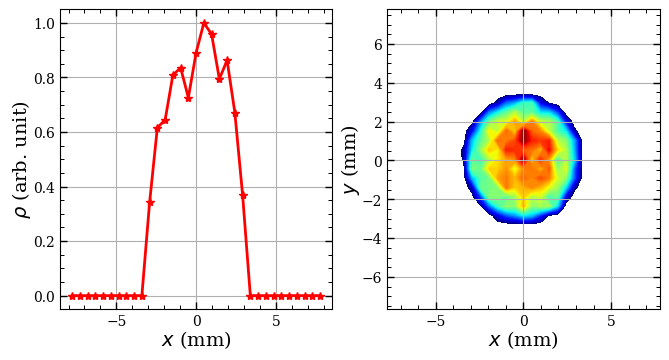

In [13]:
workdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\python\space-charge'
os.chdir(workdir)

dist = np.loadtxt('ast.0528.001')
dist[0,2] = 0; dist[1:,5] += dist[0,5]

Qtot = 100e-12
sigma_x = 1e-3; sigma_y = 1e-3; sigma_z = 1e-3
Nx, Ny, Nz = 32, 32, 32
Nc = 5
gamma0 = 1. #+150./g_mec2; print gamma

xf, yf, zf = 0*sigma_x, 0, 0

import timeit
#sc3d = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
sc3d = SpaceCharge3DFFT(Qtot, sigma_x, sigma_y, sigma_z, Nx, Ny, Nz, Nc, gamma0 = gamma0)
time1 = timeit.default_timer()
sc3d.get_rho_3D(dist = dist)
sc3d.build((xf, yf, zf))
#sc3d.build_mirror(zc = 0, xc = sigma_x*5, yc = sigma_y*5)
time2 = timeit.default_timer()
print 'time elapsed', time2-time1

0.0014574075487757258 0.0014600861792799288 0.0016166240483321181


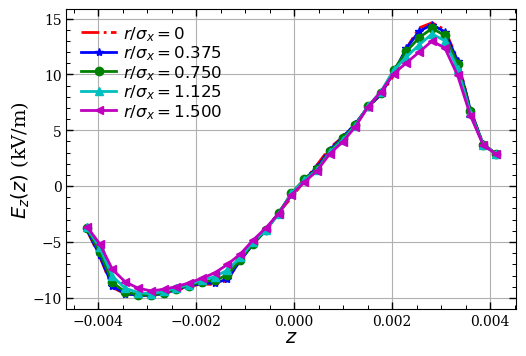

In [14]:
def demo(sc3d):
    sigma_x, sigma_y, sigma_z = sc3d.sigma_x, sc3d.sigma_y, sc3d.sigma_z
    Nx, Ny, Nz, Nc = sc3d.nx, sc3d.ny, sc3d.nz, sc3d.N_cutoff
    print sigma_x, sigma_y, sigma_z

    xx = np.linspace(-Nc*sigma_x, Nc*sigma_x, 2*Nx+1); #print xx
    yy = np.linspace(-Nc*sigma_y, Nc*sigma_y, 2*Ny+1); #print yy
    zz = np.linspace(-Nc*sigma_z, Nc*sigma_z, 2*Nz+1); #print zz
    zz = sc3d.zgrid/sc3d.gamma0

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, 0*sigma_z)[0] for x in xx])/1e3, '-*')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, 1*sigma_z)[0] for x in xx])/1e3, '-o')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, 2*sigma_z)[0] for x in xx])/1e3, '-^')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0,-1*sigma_z)[0] for x in xx])/1e3, '-o')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0,-2*sigma_z)[0] for x in xx])/1e3, '-^')
    ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    #ax.set_yticks(np.linspace(-200, 200, 11))
    ax.grid()
    ax.set_xlabel(r'$x/\sigma_x$')
    ax.set_ylabel(r'$E_x(x)$ (kV/m)')
    ax.legend([r'$\sigma_z/z = 0$', r'$\sigma_z/z = 1$', r'$\sigma_z/z = 2$', r'$\sigma_z/z = -1$', r'$\sigma_z/z = -2$'])
    fig.savefig('Ex-x-z.eps')

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 0*sigma_z)[1] for y in yy])/1e3, '-*')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 1*sigma_z)[1] for y in yy])/1e3, '-o')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 2*sigma_z)[1] for y in yy])/1e3, '-^')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y,-1*sigma_z)[1] for y in yy])/1e3, '-o')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y,-2*sigma_z)[1] for y in yy])/1e3, '-^')
    ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    ax.grid()
    ax.set_xlabel(r'$y/\sigma_y$')
    ax.set_ylabel(r'$E_y(y)$ (kV/m)')
    ax.legend([r'$\sigma_z/z = 0$', r'$\sigma_z/z = 1$', r'$\sigma_z/z = 2$', r'$\sigma_z/z = -1$', r'$\sigma_z/z = -2$'])
    fig.savefig('Ey-y-z.eps')

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(zz, np.array([sc3d.EM3D(0, 0, z)[2] for z in zz])/1e3, '-.')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*0.375, 0, z)[2] for z in zz])/1e3, '-*')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*0.750, 0, z)[2] for z in zz])/1e3, '-o')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*1.125, 0, z)[2] for z in zz])/1e3, '-^')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*1.500, 0, z)[2] for z in zz])/1e3, '-<')
    #ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    ax.grid()
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$E_z(z)$ (kV/m)')
    ax.legend([r'$r/\sigma_x = 0$', r'$r/\sigma_x = 0.375$', r'$r/\sigma_x = 0.750$',\
               r'$r/\sigma_x = 1.125$', r'$r/\sigma_x = 1.500$'])
    fig.savefig('Ez-z-x.eps')
    return
demo(sc3d)

In [1022]:
#rr = np.linspace(-Nc*sigma_x, Nc*sigma_x, Nx+1)+hx/2.+xf

xx = np.linspace(-Nc*sigma_x, Nc*sigma_x, Nx+1)
yy = np.linspace(-Nc*sigma_y, Nc*sigma_y, Ny+1)
zz = np.linspace(-Nc*sigma_z, Nc*sigma_z, Nz+1)

Ex = np.array([sc3d.EM3D(x, 0, 0)[0]-sc3d.EM3D(x, 0, 0)[4] for x in xx])
#Ey = np.array([sc3d.EM3D(0, y, 0)[1]-sc3d.EM3D(0, y, 0)[3] for y in yy])
#Ez = np.array([sc3d.EM3D(0, 0, z)[2] for z in zz])

data = np.loadtxt('R1mm.dat')

fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
ax1.plot((xx-hx/2+xf)/sigma_x, Ex/1e3, '-*')
ax1.plot(data[:,0]/sigma_x, -data[:,2]/1e3, '-')
#ax1.set_ylim(-200, 0)
ax1.grid()

ax2.plot((xx-hx/2+xf)/sigma_x, sc3d.PHI[:, Ny/2-1, Nz/2-1]*Qtot/4/np.pi/g_eps0, '-*')
ax2.plot(data[:,0]/sigma_x, data[:,1], '-')
ax2.grid()
#ax2.set_ylim(0, 500)